# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Подготовка данных

<h3>Имеем дело с задачей классификации</h3>

<h3>Признаки</h3>

* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

<h3>Целевой признак</h3>
  
* Exited — факт ухода клиента

In [1]:
import warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve

from sklearn.impute import SimpleImputer


In [2]:
data = pd.read_csv('/datasets/Churn.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


10000 объектов, не так много(

In [4]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


В признаке Tenure (количество недвижимости у клиента) есть значения NaN. Заполним NaN значением -1.

In [5]:
imp = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value=-1)
data['Tenure'] = imp.fit_transform(data[['Tenure']])

Полных дубликатов нет.

In [6]:
data.duplicated().sum()

0

In [7]:
numeric = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts',
           'HasCrCard','IsActiveMember', 'EstimatedSalary', 'Exited']

In [8]:
numeric_col_cor = ['CreditScore','Age', 'Balance','EstimatedSalary']

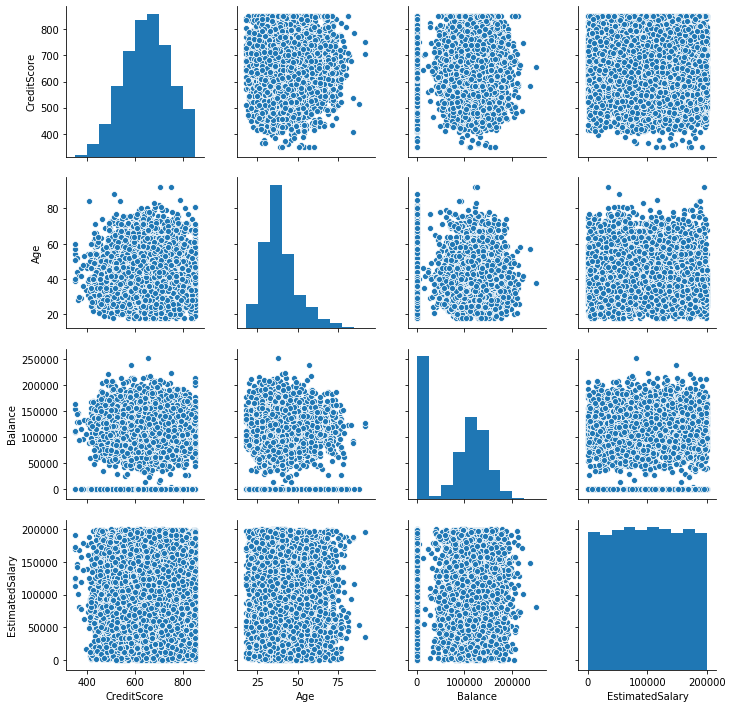

In [9]:
sns.pairplot(data[numeric_col_cor]);

In [10]:
data['Tenure'].value_counts()

 1.0     952
 2.0     950
 8.0     933
 3.0     928
 5.0     927
 7.0     925
-1.0     909
 4.0     885
 9.0     882
 6.0     881
 10.0    446
 0.0     382
Name: Tenure, dtype: int64

Сильной корреляции между данными не наблюдается. Наблюдается большое кол-ве объектов со значением 0 в признаке Balance 

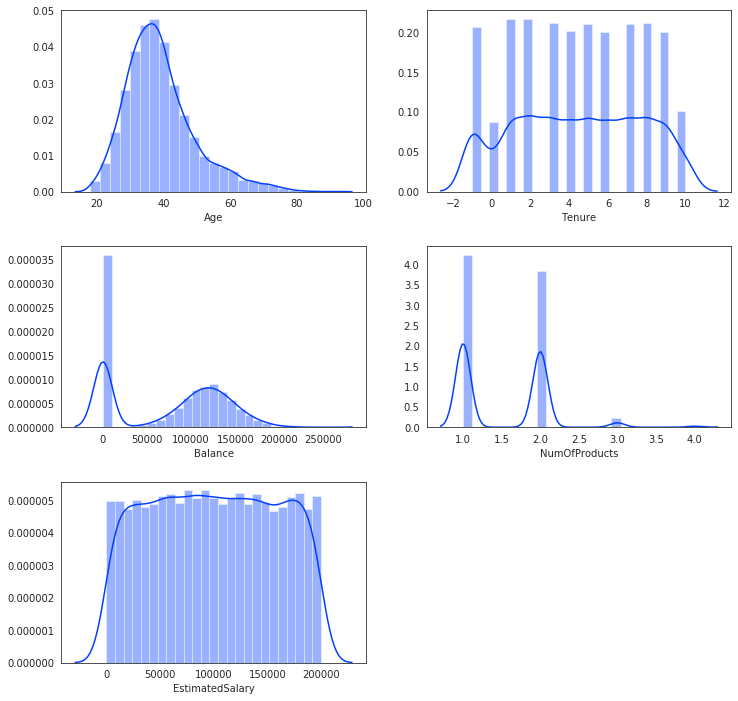

In [268]:
ser_hist = ['Age', 'Tenure','Balance','NumOfProducts','EstimatedSalary']
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.subplots_adjust(hspace = .3)
ax = axes.flatten()
ax[5].set(visible = False)

i = 0
sns.set_style("white")
sns.set_palette("bright")
for value in ser_hist:
    sns.distplot(data[value], bins = 25, label = value, ax = ax[i]);
    i += 1

In [269]:
#data['Balance'] = (data['Balance'] == 0).astype(int)

Уберем признаки Surname, CustomerId, RowNumber - они не имеют для обучения модели смысловой нагрузки.

In [270]:
data.drop(['Surname','CustomerId', 'RowNumber'], axis = 1, inplace = True)

# 2. Исследование задачи

<h3>Логистическая регрессия</h3>

**Признаки : Geography, Gender - категориальные. Преобразуем их для логистической регрессии в количественные с помощью техники One-Hot Encoding, добавив dummy-признаки и исключив появление dummy-ловушки.**

In [271]:
features = data.drop('Exited', axis = True)
target = data['Exited']

In [272]:
features['Gender'] = (features['Gender'] == 'Male').astype(int)

In [273]:
ohencoder = OneHotEncoder()
ohencoder.fit(features[['Geography']])

geo_train_ohe = pd.DataFrame(ohencoder.transform(
                                        features[['Geography']]).toarray(),
                                          columns = ohencoder.categories_[0])

In [274]:
features_ohe = features.join(geo_train_ohe)

In [275]:
features_ohe.drop('Geography', axis = 1, inplace = True)

**Разобъем выборки в соотношении 80%-20% (тренировочная, тестовая)**

In [276]:
features_train_ohe, features_valid_ohe, target_train, target_valid = train_test_split(
    features_ohe, target, test_size=0.2, random_state=12345)

Масштабируем количественные признаки с помощью StandardScaler

In [277]:
scalar_numeric = ['CreditScore','Age', 'Tenure','Balance', 'NumOfProducts','EstimatedSalary']

In [278]:
scaler = StandardScaler()
scaler.fit(features_train_ohe.loc[:,scalar_numeric])
features_train_ohe.loc[:,scalar_numeric] = scaler.transform(features_train_ohe.
                                                            loc[:,scalar_numeric])
features_valid_ohe.loc[:,scalar_numeric] = scaler.transform(features_valid_ohe.
                                                            loc[:,scalar_numeric])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [279]:
f1 = make_scorer(f1_score)

**Обучаем модель с помощью Логистической регрессии, перебирая значения регуляризации penalty и значения коэффициента регуляризации С.**

In [280]:
param_grid = {'penalty' : ['l1','l2'], 'C' : [0.1, 0.2, 0.5, 0.7,1]}
gs_log_reg = GridSearchCV(LogisticRegression(random_state=12345, solver = 'liblinear',
                                        ), param_grid = param_grid, scoring = f1)
gs_log_reg.fit(features_train_ohe,target_train)
display(gs_log_reg.best_params_,
        gs_log_reg.best_score_)
c, pen = gs_log_reg.best_params_.values()

{'C': 0.5, 'penalty': 'l2'}

0.31934912164256984

In [281]:
log_reg = LogisticRegression(random_state=12345, penalty = pen, C = c, solver = 'liblinear')
log_reg.fit(features_train_ohe,target_train)
log_reg_predictions = log_reg.predict(features_valid_ohe)
print(classification_report(target_valid, log_reg_predictions))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1573
           1       0.57      0.19      0.28       427

    accuracy                           0.80      2000
   macro avg       0.69      0.57      0.58      2000
weighted avg       0.76      0.80      0.75      2000



In [282]:
probabilities_valid = log_reg.predict_proba(features_valid_ohe)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_log_reg = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_log_reg

0.7577355580336207

В отсутствии баланса целевого признака, f1-score в логистической регрессии показывает низкий результат

<h3>Дерево решений</h3>

**Для Дерева решений и Случайного леса воспользуемся порядковым кодированием Ordinal Encoding**

In [283]:
encoder = OrdinalEncoder()
features_ordinal['Geography'] = pd.DataFrame(encoder.fit_transform(features[['Geography']]), 
                                columns = ['Geography'])
features_ordinal.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0
1,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0
2,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0
3,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0
4,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0


In [284]:
features_ord_train, features_ord_valid, target_train, target_valid = train_test_split(features_ordinal, 
                                                target, test_size=0.2, random_state=12345)

**Обучаем модель с помощью Дерева решений, перебирая значения глубины max_depth**

In [285]:
param_grid = {'max_depth' : [deep for deep in range(2,16)]}
gs_tree = GridSearchCV(DecisionTreeClassifier(random_state=12345
                                        ), param_grid = param_grid, scoring = f1)
gs_tree.fit(features_ord_train,target_train)
display(gs_tree.best_params_,
gs_tree.best_score_)
tree_depth = gs_tree.best_params_['max_depth']

{'max_depth': 5}

0.5400705859400816

In [286]:
tree = DecisionTreeClassifier(random_state=12345, max_depth = tree_depth)
tree.fit(features_ord_train,target_train)
tree_predictions = tree.predict(features_ord_valid)
print(classification_report(target_valid, tree_predictions))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1573
           1       0.76      0.40      0.52       427

    accuracy                           0.84      2000
   macro avg       0.81      0.68      0.71      2000
weighted avg       0.83      0.84      0.82      2000



In [287]:
probabilities_valid = tree.predict_proba(features_ord_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_tree = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_tree

0.8450684933546334

<h3>Случайный лес</h3>

**Обучаем модель с помощью Случайного леса, перебирая значения глубины max_depth и значения кол-ва деревьев n_estimators, при этом уменьшая рассматриваемый диапазон гиперпараметров.**

In [288]:
param_grid = {'max_depth' : [deep for deep in range(2,16)]}
gs_forest = GridSearchCV(RandomForestClassifier(random_state=12345, n_estimators = 20
                                        ), param_grid = param_grid,scoring = f1)
gs_forest.fit(features_ord_train,target_train)
display(gs_forest.best_params_,
        gs_forest.best_score_)
depth = gs_forest.best_params_['max_depth']

{'max_depth': 13}

0.5656812269417413

In [289]:
param_grid = { 'n_estimators' : [estim for estim in range(20,100,10)]}
gs_forest = GridSearchCV(RandomForestClassifier(random_state=12345, max_depth = depth
                                        ), param_grid = param_grid, scoring = f1)
gs_forest.fit(features_ord_train,target_train)
display(gs_forest.best_params_,
        gs_forest.best_score_)
curr_estim = gs_forest.best_params_['n_estimators']

{'n_estimators': 90}

0.570449683933889

In [290]:
param_grid = {'n_estimators' : [estim for estim in range(curr_estim,curr_estim + 20)]}
gs_forest = GridSearchCV(RandomForestClassifier(random_state=12345, max_depth = depth
                                        ), param_grid = param_grid, scoring = f1)
gs_forest.fit(features_ord_train,target_train)
display(gs_forest.best_params_,
        gs_forest.best_score_)

estim = gs_forest.best_params_['n_estimators']

{'n_estimators': 105}

0.5706874988174215

In [291]:
forest = RandomForestClassifier(random_state=12345, max_depth = depth,n_estimators = estim)
forest.fit(features_ord_train,target_train)
predictions_forest = forest.predict(features_ord_valid)
print(classification_report(target_valid, predictions_forest))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1573
           1       0.77      0.41      0.53       427

    accuracy                           0.85      2000
   macro avg       0.81      0.69      0.72      2000
weighted avg       0.84      0.85      0.83      2000



In [292]:
probabilities_valid = forest.predict_proba(features_ord_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc_forest

0.8584991759358376

In [293]:
model_relevance = (pd.DataFrame(columns = ['algoritm','precision',
                                    'recall','f1-score','auc-roc']). astype('object'))
model_relevance.loc[0,:] = ('DecisionTreeClassifier', 
                            precision_score(target_valid, tree_predictions), 
                            recall_score(target_valid, tree_predictions), 
                            f1_score(target_valid, tree_predictions), auc_roc_tree)

model_relevance.loc[1,:] = ('LogisticRegression',
                            precision_score(target_valid, log_reg_predictions), 
                            recall_score(target_valid, log_reg_predictions),
                            f1_score(target_valid, log_reg_predictions), auc_roc_log_reg)

model_relevance.loc[2,:] = ('RandomForestClassifier',
                            precision_score(target_valid, predictions_forest), 
                            recall_score(target_valid, predictions_forest),
                            f1_score(target_valid, predictions_forest), auc_roc_forest)

model_relevance

,algoritm,precision,recall,f1-score,auc-roc
0,DecisionTreeClassifier,0.755556,0.398126,0.521472,0.845068
1,LogisticRegression,0.571429,0.187354,0.282187,0.757736
2,RandomForestClassifier,0.769912,0.407494,0.532925,0.858499


**От наличия дисбаланса сильнее всех страдает модель, обученная Логистической регрессией. Далее для обучения модели будем использовать алгоритм Случайного леса, так как он дает наилучшие показатели.**

# 3. Борьба с дисбалансом

Техника балансировки через увеличения выборки UPSAMPLING

In [294]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [295]:
features_upsampled, target_upsampled = upsample(features_ord_train, target_train, 4)

In [296]:
display(target_upsampled.value_counts(normalize = True),target_upsampled.value_counts())

1    0.501949
0    0.498051
Name: Exited, dtype: float64

1    6440
0    6390
Name: Exited, dtype: int64

Техника балансировки через уменьшение выборки DOWNSAMPLING

In [297]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [298]:
features_downsampled, target_downsampled = downsample(features_ord_train, target_train, 0.25)

In [299]:
display(target_downsampled.value_counts(normalize = True),target_downsampled.value_counts())

1    0.50187
0    0.49813
Name: Exited, dtype: float64

1    1610
0    1598
Name: Exited, dtype: int64

Обучаем модели двумя техниками и сравниваем характеристики

**UPSAMPLING**

In [300]:
forest_bal = RandomForestClassifier(random_state=12345, max_depth = depth,n_estimators = estim)
forest_bal.fit(features_upsampled,target_upsampled)
predicted_forest_bal = forest_bal.predict(features_ord_valid)

print(classification_report(target_valid, predicted_forest_bal))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1573
           1       0.61      0.61      0.61       427

    accuracy                           0.83      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000



In [301]:
probabilities_valid_forest = forest_bal.predict_proba(features_ord_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc_forest_bal = roc_auc_score(target_valid, probabilities_one_valid_forest)
auc_roc_forest_bal

0.8584708882771475

**DOWNSAMPLING**

In [302]:
forest_bal_dwn = RandomForestClassifier(random_state=12345, max_depth = depth,
                                        n_estimators = estim)
forest_bal_dwn.fit(features_downsampled, target_downsampled)
predicted_forest_bal_dwn = forest_bal_dwn.predict(features_ord_valid)

print(classification_report(target_valid, predicted_forest_bal_dwn))

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1573
           1       0.48      0.79      0.60       427

    accuracy                           0.78      2000
   macro avg       0.71      0.78      0.72      2000
weighted avg       0.83      0.78      0.79      2000



In [303]:
probabilities_valid_forest = forest_bal_dwn.predict_proba(features_ord_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc_forest_bal_dwn = roc_auc_score(target_valid, probabilities_one_valid_forest)
auc_roc_forest_bal_dwn

0.8579661768931514

In [304]:

model_balanced = (pd.DataFrame(columns = ['technic','precision','recall','f1-score',
                                          'auc-roc']). astype('object'))

model_balanced.loc[0,:] = ('UPSAMPLING',
                           precision_score(target_valid, predicted_forest_bal), 
                           recall_score(target_valid, predicted_forest_bal),
                           f1_score(target_valid, predicted_forest_bal), auc_roc_forest_bal)

model_balanced.loc[1,:] = ('DOWNSAMPLING',
                           precision_score(target_valid, predicted_forest_bal_dwn), 
                           recall_score(target_valid, predicted_forest_bal_dwn),
                           f1_score(target_valid, predicted_forest_bal_dwn), auc_roc_forest_bal_dwn)


display(model_balanced)

,technic,precision,recall,f1-score,auc-roc
0,UPSAMPLING,0.613208,0.608899,0.611046,0.858471
1,DOWNSAMPLING,0.483453,0.786885,0.59893,0.857966


Техника UPSAMPLING показала лучшие характеристики. 

Разберем значимость признаков для нашей модели

In [305]:
importances = pd.DataFrame(columns = features_ordinal.columns)
importances.loc[0] = forest_bal.feature_importances_
importances

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,0.114045,0.041863,0.022311,0.275902,0.063717,0.132027,0.167649,0.015286,0.049289,0.11791


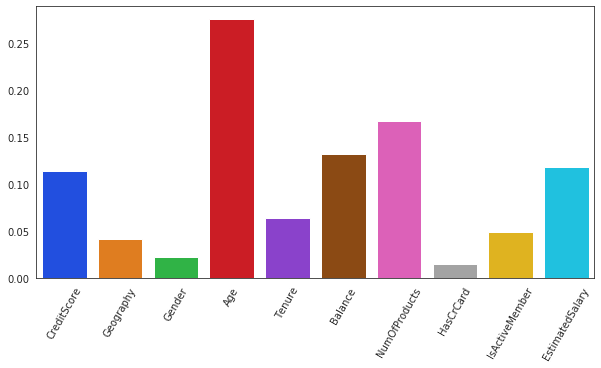

In [306]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.set_xticklabels(labels = features_ordinal.columns,rotation=60)
sns.barplot(y = forest_bal.feature_importances_, x = features_ordinal.columns, ax = axes);

Наименее значимый признак при обучении нашей модели оказался HasCrCard - есть ли у клиента карта. Обучим модель без HasCrCard, сравним с моделью с этим признаком.

In [307]:
features_w_card = features_upsampled.drop('HasCrCard', axis = 1)
features_val_w_card  = features_ord_valid.drop('HasCrCard', axis = 1)

forest_bal_card = RandomForestClassifier(random_state=12345, max_depth = depth,
                                         n_estimators = estim)
forest_bal_card.fit(features_w_card,target_upsampled)
predicted_forest_card = forest_bal_card.predict(features_val_w_card)

print(classification_report(target_valid, predicted_forest_card))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1573
           1       0.60      0.61      0.61       427

    accuracy                           0.83      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000



In [308]:
probabilities_valid_forest = forest_bal_card.predict_proba(features_val_w_card)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc_forest_bal_card = roc_auc_score(target_valid, probabilities_one_valid_forest)
auc_roc_forest_bal_card

0.8569880194321327

In [309]:
model_feat_imp = (pd.DataFrame(columns = ['changes','precision','recall','f1-score',
                                          'auc-roc']). astype('object'))

model_feat_imp.loc[0,:] = ('before',
                           precision_score(target_valid, predicted_forest_bal), 
                           recall_score(target_valid, predicted_forest_bal),
                           f1_score(target_valid, predicted_forest_bal), auc_roc_forest_bal)

model_feat_imp.loc[1,:] = ('without_HasCrCard',
                           precision_score(target_valid, predicted_forest_card), 
                           recall_score(target_valid, predicted_forest_card),
                           f1_score(target_valid, predicted_forest_card), auc_roc_forest_bal_card)


display(model_feat_imp)

,changes,precision,recall,f1-score,auc-roc
0,before,0.613208,0.608899,0.611046,0.858471
1,without_HasCrCard,0.601382,0.611241,0.606272,0.856988


Характеристики модели не улучшились, оставим признак HasCrCard.

# 4. Тестирование модели

In [310]:
predicted_data = forest_bal.predict(features_ord_valid)
print(classification_report(target_valid, predicted_data))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1573
           1       0.61      0.61      0.61       427

    accuracy                           0.83      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.83      0.83      0.83      2000



In [311]:
probabilities_valid_forest = forest_bal.predict_proba(features_ord_valid)
probabilities_one_valid_forest = probabilities_valid_forest[:, 1]

auc_roc_forest_bal = roc_auc_score(target_valid, probabilities_one_valid_forest)
display('AUC-ROC:',auc_roc_forest_bal)

'AUC-ROC:'

0.8584708882771475

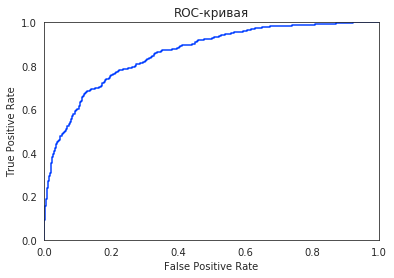

In [312]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid_forest)
plt.figure()

plt.plot(fpr, tpr)
plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC-кривая")
plt.show()

При обучении модели с помощью алгоритма Случайного леса при глубине дерева равного 9 и кол-ве деревьев 34, f1-мера = 0.63, точность 0.55, полнота 0.72, AUC-ROC 0.86.

## Что было сделано

**Загрузили и подготовил данные. Посмотрели на взаимосвязи признаков, заполнили пропуски, убрали поля, не влияющие на обучение модели. Сделали масштабирование признаков. Перевели категориальные признаки в количественные. Разбили данные.**

---

**Исследовали баланс классов, обучили модель с помощью кросс-валидации без учёта дисбаланса. Выбрали алгоритм обучения.**

---

**Улучшили качество модели, учитывая дисбаланс классов. Произвели баланс классов с помощью техник upsampling, downsampling и выбрали лучшую. Посмотрели влияние признаков на обучение модели. Добились необходимых характеристик модели.**

---

**Провели финальное тестирование.**

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*